## imports 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential, layers, Input
import ipyplot
import cv2

## clean up your messy dataset

I actually tried masking. the images don't give in. I can't get a good threshold for cutting out the unwanted part of the images. Might later try thresholding on every single colour and then mix the resulting three masks.

In [2]:
imgs_path = os.getcwd() + "/samples"

h=w=100 # height and width of the images we will feed into nn
x = []
y = []
for i in os.listdir(imgs_path):
    for j in os.listdir(imgs_path+"/"+i):
        _im = cv2.imread (imgs_path+"/"+i+"/"+j)
        _im = cv2.cvtColor(_im, cv2.COLOR_RGB2BGR)
        _im = cv2.resize(_im, (h, w), interpolation=cv2.INTER_NEAREST)
        x.append(_im)
        y.append(i)
        pass
    pass

#ipyplot.plot_images(x, max_images=30 , img_width=80)
print("shape of one image {}".format(x[0].shape))
print("len x {} len y{} ".format(len(x),len(y)))

shape of one image (100, 100, 3)
len x 12567 len y12567 


In [3]:
# Model parameters
num_classes = len(set(y))
input_shape = (h, w, 3) # 3 colour channels

x = np.array(x, dtype=np.float32) / 255

from sklearn.preprocessing import LabelBinarizer
import pandas as pd
encoder = LabelBinarizer()
encoder.fit(list(set(y)))
ef = pd.DataFrame(encoder.classes_)
ef.to_csv('labels.csv', index=False, header=False)
y = encoder.transform(y)

# Load the data and split it between train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

#ipyplot.plot_images(x_train, max_images=30 , img_width=80)

x_train shape: (8419, 100, 100, 3)
8419 train samples
4148 test samples


## make model

In [4]:
model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dropout (Dropout)           (None, 33856)             0

## do the actual work

In [5]:
batch_size = 128
epochs = 30

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
60/60 [==============================] - 27s 450ms/step - loss: 1.3429 - accuracy: 0.6691 - val_loss: 0.3470 - val_accuracy: 0.9050
Epoch 2/30
60/60 [==============================] - 34s 565ms/step - loss: 0.1497 - accuracy: 0.9584 - val_loss: 0.1188 - val_accuracy: 0.9679
Epoch 3/30
60/60 [==============================] - 28s 463ms/step - loss: 0.0577 - accuracy: 0.9846 - val_loss: 0.0804 - val_accuracy: 0.9857
Epoch 4/30
60/60 [==============================] - 28s 465ms/step - loss: 0.0276 - accuracy: 0.9937 - val_loss: 0.0721 - val_accuracy: 0.9846
Epoch 5/30
60/60 [==============================] - 27s 448ms/step - loss: 0.0204 - accuracy: 0.9951 - val_loss: 0.0716 - val_accuracy: 0.9917
Epoch 6/30
60/60 [==============================] - 27s 452ms/step - loss: 0.0116 - accuracy: 0.9978 - val_loss: 0.0587 - val_accuracy: 0.9929
Epoch 7/30
60/60 [==============================] - 25s 419ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0562 - val_accuracy: 0.9929

## Prints and Plots

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.035178594291210175
Test accuracy: 0.9949373006820679


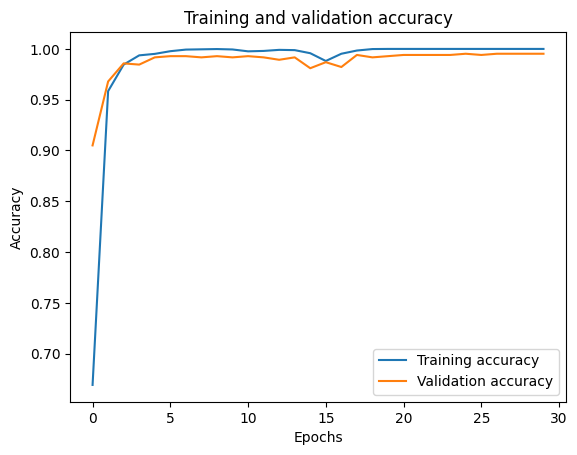

In [7]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()

In [8]:
model.save('obj_classification_small_model.h5')